In [7]:
# Instalar os pacotes.
# !pip install lightgbm
# !pip install xgboost
# !pip install shap

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import lightgbm as lgb
import time
import numpy as np

In [13]:
# Lendo os dados.
X_train = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula3_X_train.pkl')
y_train = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula3_y_train.pkl')
X_test = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula3_X_test.pkl')
y_test = pd.read_pickle('/root/MBA_USP_Data_Science_Analytics/11. Árvores, Redes e Ensemble Models/Dados/aula3_y_test.pkl')

In [14]:
# Identificar e remover colunas duplicadas.
duplicated_columns = X_train.columns[X_train.columns.duplicated()]
print(f'Colunas duplicadas: {duplicated_columns}')
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

Colunas duplicadas: Index([], dtype='object')


In [15]:
# Ajuste de Índice.
X_train.set_index('subject', append=True, inplace=True)
X_test.set_index('subject', append=True, inplace=True)

In [18]:
# Adicionando a coluna de resposta no dataframe de treino.
HAR_train = pd.concat([X_train.reset_index(), y_train], axis=1).set_index(['level_0', 'subject'])
HAR_train.head()

,,000-tBodyAcc-mean-X,001-tBodyAcc-mean-Y,002-tBodyAcc-mean-Z,003-tBodyAcc-std-X,004-tBodyAcc-std-Y,005-tBodyAcc-std-Z,006-tBodyAcc-mad-X,007-tBodyAcc-mad-Y,008-tBodyAcc-mad-Z,009-tBodyAcc-max-X,...,552-fBodyBodyGyroJerkMag-skewness,553-fBodyBodyGyroJerkMag-kurtosis,554-angletBodyAccMeangravity,555-angletBodyAccJerkMeangravityMean,556-angletBodyGyroMeangravityMean,557-angletBodyGyroJerkMeangravityMean,558-angleXgravityMean,559-angleYgravityMean,560-angleZgravityMean,label
level_0,subject,,,,,,,,,,,,,,,,,,,,,
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,1,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,1,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [19]:
# Visualizar Colunas.
print(HAR_train.columns)

Index(['000-tBodyAcc-mean-X', '001-tBodyAcc-mean-Y', '002-tBodyAcc-mean-Z',
       '003-tBodyAcc-std-X', '004-tBodyAcc-std-Y', '005-tBodyAcc-std-Z',
       '006-tBodyAcc-mad-X', '007-tBodyAcc-mad-Y', '008-tBodyAcc-mad-Z',
       '009-tBodyAcc-max-X',
       ...
       '552-fBodyBodyGyroJerkMag-skewness',
       '553-fBodyBodyGyroJerkMag-kurtosis', '554-angletBodyAccMeangravity',
       '555-angletBodyAccJerkMeangravityMean',
       '556-angletBodyGyroMeangravityMean',
       '557-angletBodyGyroJerkMeangravityMean', '558-angleXgravityMean',
       '559-angleYgravityMean', '560-angleZgravityMean', 'label'],
      dtype='object', length=562)


/tmp/ipykernel_102111/1113567105.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)
/tmp/ipykernel_102111/1113567105.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
/tmp/ipykernel_102111/1113567105.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=30)


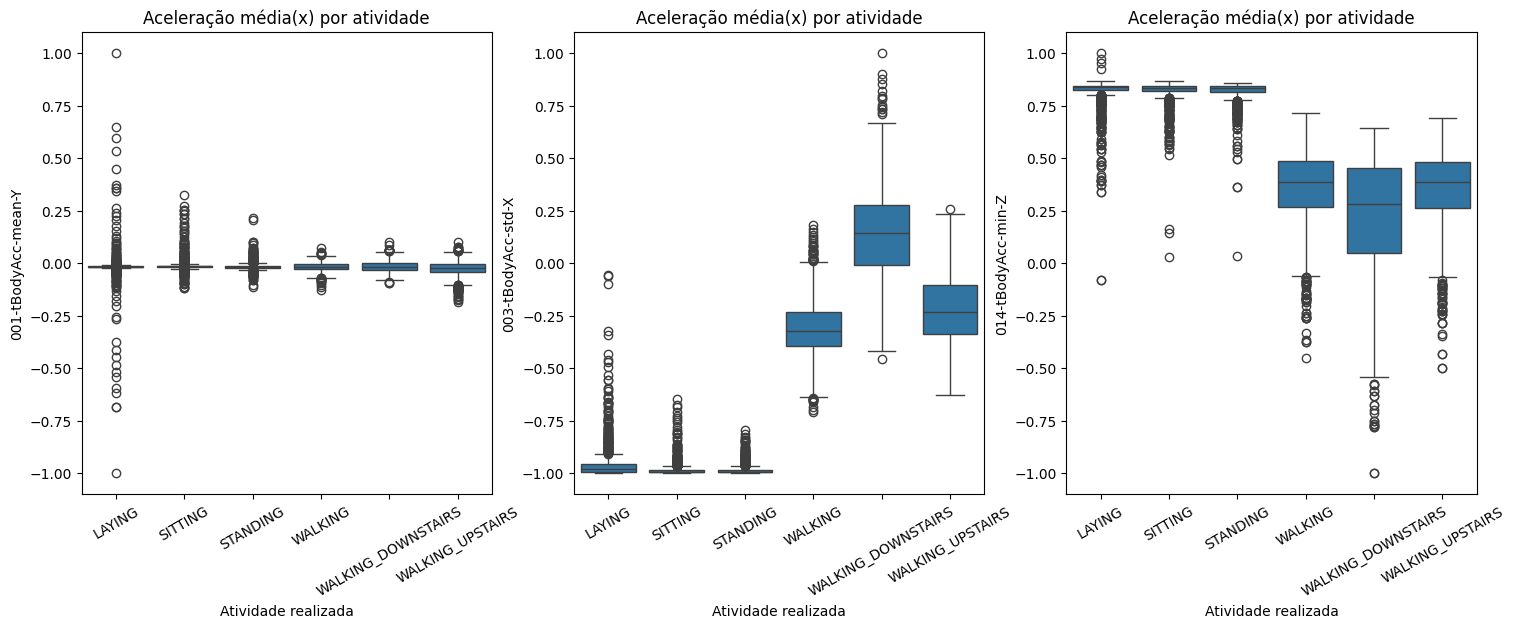

In [20]:
# Análise Descritiva Básica.
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 1], ax=axs[0])
axs[0].set_xlabel("Atividade realizada")
axs[0].set_ylabel(HAR_train.columns[1])
axs[0].set_title("Aceleração média(x) por atividade")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 3], ax=axs[1])
axs[1].set_xlabel("Atividade realizada")
axs[1].set_ylabel(HAR_train.columns[3])
axs[1].set_title("Aceleração média(x) por atividade")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 14], ax=axs[2])
axs[2].set_xlabel("Atividade realizada")
axs[2].set_ylabel(HAR_train.columns[14])
axs[2].set_title("Aceleração média(x) por atividade")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=30)

plt.show()

In [21]:
# Treinamento do Modelo de Decisão.
np.random.seed(1729)
tempo_ini = time.time()
arvore = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2)
arvore.fit(X_train, y_train)
tempo_fim = time.time()
print(f'Tempo de treinamento da árvore: {tempo_fim - tempo_ini} segundos')

importancias = pd.DataFrame(arvore.feature_importances_, index=X_train.columns, columns=['importancia'])
top_10_variaveis = importancias.sort_values(by='importancia', ascending=False)[:10]
print(f'Top 10 variaveis: {top_10_variaveis}')

# Selecionar as 20 variáveis com maior importância
variaveis = importancias.nlargest(20, 'importancia').index.tolist()
print(f'Variáveis selecionadas: {variaveis}')

# Parâmetros para o Grid Search
param_grid = {
    'num_leaves': [31],
    'max_depth': [3, 10],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [5, 11]
}

Tempo de treinamento da árvore: 4.86961817741394 segundos
Top 10 variaveis:                                   importancia
389-fBodyAccJerk-bandsEnergy-116     0.417352
052-tGravityAcc-min-X                0.217220
504-fBodyAccMag-mad                  0.091258
559-angleYgravityMean                0.076230
074-tGravityAcc-arCoeff-Z2           0.058416
448-fBodyGyro-maxInds-X              0.016524
159-tBodyGyro-correlation-YZ         0.013493
057-tGravityAcc-energy-Y             0.013026
037-tBodyAcc-correlation-XY          0.012383
049-tGravityAcc-max-X                0.011793
Variáveis selecionadas: ['389-fBodyAccJerk-bandsEnergy-116', '052-tGravityAcc-min-X', '504-fBodyAccMag-mad', '559-angleYgravityMean', '074-tGravityAcc-arCoeff-Z2', '448-fBodyGyro-maxInds-X', '159-tBodyGyro-correlation-YZ', '057-tGravityAcc-energy-Y', '037-tBodyAcc-correlation-XY', '049-tGravityAcc-max-X', '039-tBodyAcc-correlation-YZ', '274-fBodyAcc-max-X', '508-fBodyAccMag-energy', '275-fBodyAcc-max-Y', '354-fBody

In [22]:
# Verificação de Valores Faltantes.
print(X_train[variaveis].isna().sum())
print(y_train.isna().sum())

389-fBodyAccJerk-bandsEnergy-116    0
052-tGravityAcc-min-X               0
504-fBodyAccMag-mad                 0
559-angleYgravityMean               0
074-tGravityAcc-arCoeff-Z2          0
448-fBodyGyro-maxInds-X             0
159-tBodyGyro-correlation-YZ        0
057-tGravityAcc-energy-Y            0
037-tBodyAcc-correlation-XY         0
049-tGravityAcc-max-X               0
039-tBodyAcc-correlation-YZ         0
274-fBodyAcc-max-X                  0
508-fBodyAccMag-energy              0
275-fBodyAcc-max-Y                  0
354-fBodyAccJerk-max-Y              0
129-tBodyGyro-max-X                 0
451-fBodyGyro-meanFreq-X            0
075-tGravityAcc-arCoeff-Z3          0
053-tGravityAcc-min-Y               0
222-tGravityAccMag-arCoeff1         0
dtype: int64
label    0
dtype: int64


In [24]:
# Preparação da Variável y.
y = y_train['label'].cat.codes
y.head()

0    2
1    2
2    2
3    2
4    2
dtype: int8

In [25]:
# Configuração de GridSearchCV.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1729)
scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Inicia o cronômetro.
tempo_ini = time.time()

# Definindo o modelo LightGBM.
modelo = lgb.LGBMClassifier(objective='multiclass', random_state=1729)

# Realizando o Grid Search.
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train[variaveis], y)

# Finaliza o cronômetro.
tempo_fim = time.time()
print(f'Tempo de treinamento do Grid Search: {tempo_fim - tempo_ini} segundos')

# Exibindo os melhores parâmetros.
print(f'Melhores Parâmetros: {grid_search.best_params_}')

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4866
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Info] Start training from score -1.653445
[LightGBM] [Info] Start training from score -1.743757
[LightGBM] [Info] Start training from score -1.677178
[LightGBM] [Info] Start training from score -1.790332
[LightGBM] [Info] Start training from score -2.009511
[LightGBM] [Info] Start training from score -1.924912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [27]:
# Resultados.
resultados_cv = pd.DataFrame(grid_search.cv_results_)
resultados_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.393221,0.241823,0.046800,0.024156,0.05,3,5,31,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.992933,0.993505,0.993042,0.993160,0.000248,8
1,0.800183,0.512924,0.033565,0.012750,0.05,3,11,31,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.995142,0.995273,0.994663,0.995026,0.000262,7
2,2.720894,3.427607,0.034808,0.011629,0.05,10,5,31,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.997344,0.996656,0.996309,0.996770,0.000430,5
3,20.974784,2.565417,0.081329,0.047918,0.05,10,11,31,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.997815,0.997598,0.997515,0.997643,0.000126,3
4,3.671270,0.111183,0.045879,0.033947,0.20,3,5,31,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.995640,0.995840,0.995392,0.995624,0.000183,6
5,6.980583,0.370064,0.045206,0.013927,0.20,3,11,31,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.997332,0.997403,0.997104,0.997279,0.000128,4
6,3.145027,3.528450,0.025782,0.005039,0.20,10,5,31,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.998120,0.997918,0.997827,0.997955,0.000122,2
7,5.843114,0.897326,0.044841,0.007172,0.20,10,11,31,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.998910,0.998851,0.998699,0.998820,0.000089,1


In [28]:
# Demais resultados.
pred_test = pd.Series(grid_search.best_estimator_.predict(X_test[variaveis]))
print(pd.crosstab(pred_test, y_test.label))
acurácia = (pred_test == y_test.label.cat.codes).sum()/len(y_test)
print(f'acurácia = {acurácia:.2%}')

label  LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
row_0                                                           
0         537        0         0        0                   0   
1           0      380        57        0                   0   
2           0      108       475        0                   0   
3           0        0         0      449                   6   
4           0        1         0       25                 377   
5           0        2         0       22                  37   

label  WALKING_UPSTAIRS  
row_0                    
0                     0  
1                     1  
2                     1  
3                    52  
4                    21  
5                   396  
acurácia = 88.70%
